<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.HousePrices/blob/NewProcessing/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objectives:
1. Learn important feature selection
- SelectKBest from scikit learn
- Correlation matrix
- Feature importance from classifiers

### Train preparation:
1. Delete certain Nan cols
2. Keep only selected numeric & categorical features


## Packages

In [452]:
!pip install catboost

In [453]:
!pip install category_encoders

In [454]:
import pandas as pd
import numpy as np
from google.colab import drive

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Printing
import pprint

# Feature selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

# Encoding
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import skew

# Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# For my functions
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

## Constants

In [455]:
train_proportion = 0.9
validation_proportion = 0.1
rand_state = 42

# Feature selection
select_k_numerics = 30  # select 20 out of 36 numeric features
nan_drop_thresh = 0.25

## Functions

In [456]:
def nan_statistics(df, nan_thresh=0.0):
    res = {}
    nan_cols = df.loc[:, df.isna().any()].columns
    for col in nan_cols:
        res[col] = nan_percentage(df, col)
    print(f'Col -- Nan percentage')
    for key, val in sorted(res.items(), key=lambda item: item[1], reverse=True):
        if val >= nan_thresh * 100:
            print(key, val)
        else:
            del res[key]
    return res

def nan_percentage(df, colname):
    return (df[colname].isnull().sum() / df.shape[0]) * 100

def corr_filter(corr_matrix, target_feature, abs_thresh=0.3):
    res = {}
    series = corr_matrix[target_feature]
    for idx, val in series.items():
        if abs(val) >= abs_thresh:
            res[idx] = val  # Feature names and corr coeff
    return res

def print_unique_dtypes(df):
    print(set(train.dtypes.values))

class FeaturesTransformers:
    def __init__(self, features, transformers):
        self.features = features
        self.transformers = transformers

In [457]:
def build_pipe(model, **transformers):
    res_transformers = []
    for key, val in transformers.items():
        res_transformers.append((key, val.transformers, val.features))

    preprocess = ColumnTransformer(
        res_transformers
    )
    
    pipe = Pipeline(
        steps = [
                 ('preprocessing', preprocess),
                 ('model', model)
        ]
    )
    return pipe

def first_tune(models, scoring, X_train, Y_train, transformers):
    res = dict()
    for name, model in models:
        model_pipeline = build_pipe(model, **transformers)
        cv_scores = cross_val_score(model_pipeline, X_train, Y_train, scoring=scoring)
        res[name] = cv_scores

    return dict(sorted(res.items(), reverse=True, key=lambda x: np.mean(x[1])))

In [458]:
def fine_tune(models, X_train, Y_train, strategy, search_params, transformers):

    fine_tune_res = {}

    for name, model, param_grid in models:
        print(search_params)
        pipe = build_pipe(model, **transformers)

        if strategy == 'GridSearchCV':
            search_res = GridSearchCV(
                estimator = pipe, 
                param_grid = param_grid,
                **search_params
            )

        elif strategy == 'RandomizedSearchCV':
            search_res = RandomizedSearchCV(
                pipe, 
                param_grid,
                **search_params
            )
        search_res.fit(X_train, Y_train)
        fine_tune_res[name] = search_res
    
    return dict(sorted(fine_tune_res.items(), reverse=True, key=lambda x: x[1].best_score_))

In [459]:
import seaborn as sns
import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt

def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go throug desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1.set(xlabel='Original ' + col)
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2.set(xlabel='Transformed ' + col)
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2.set(xlabel='NO TRANSFORM ' + col)
                plt.show()
                

    return DF

In [460]:
def get_order(df, feature):
    # Impose order depending on the median price
    subset = df[[feature, 'SalePrice']]
    s = subset.groupby([feature]).median().sort_values(by='SalePrice')
    return list(s.index)

def prepare_labels(ordered_features):
    return {k: ordered_features.index(k) + 1 for k in ordered_features}

## Transformers

In [461]:
from abc import abstractmethod

class Transformer:
    def __init__(self):
        pass
    @abstractmethod
    def transform():
        pass

class NanRemover(Transformer):
    def __init__(self):
        super().__init__()

    def transform(df, cols):
        df.drop(columns = cols, inplace=True)

class NanCatFiller(Transformer):
    def __init__(self):
        super().__init()
    
    def transform(df, cols, val):
        for c in cols:
            df[c].fillna(value=val, inplace=True)

class NanNumFiller(Transformer):
    def __init__(self):
        super().__init__()

    def transform(df, cols, method):
        if method == 'median':
            for c in cols:
                df[c].fillna(value=df[c].median(), inplace=True)

class CatEncoder(Transformer):
    def __init__(self):
        super().__init__()

    def transform(df, colname, dictionary):
        # dict with cat_feature_name: new_value
        # dict = {'FeatureA': 1} // encoded value
        series = df[colname]  # Series
        for f_name, new_val in dictionary.items():
            series[series == f_name] = new_val
        df[colname] = series

class ColumnKeeper(Transformer):
    def __init__(self):
        super().__init__()
    
    def transform(df, features_to_keep):
        df.drop(df.columns.difference(features_to_keep), 1, inplace=True)

In [462]:
class LogTransformer(Transformer):
    def __init__(self):
        super().init()
    def transform(df, colnames, offset=0.001):
        for c in colnames:
            df[c] = df[c].map(lambda i: np.log(i) if i > 0 else np.log(i + offset))

In [463]:
class QuantileRemover(Transformer):
    def __init__(self):
        super().__init__()
    
    def transform(df, cols, percent_low, percent_high):
        for c in cols:
            q_low = df[c].quantile(percent_low)
            q_high = df[c].quantile(percent_high)
            df = df[df[c].between(q_low, q_high)]
            #return df[(df[c] > q_low) & (df[c] < q_high)]
            return df

class IQRRemover(Transformer):
    def __init__(self):
        super().__init__()
    
    def transform(df, columns, range_width=1.5):
        for c in columns:
            Q1 = df[c].quantile(0.25)
            Q3 = df[c].quantile(0.75)
            IQR = Q3 - Q1
            df = df[(df[c] < Q1 - range_width * IQR) & 
                    (df[c] > Q3 + range_width * IQR)]
            return df

## Data download

In [464]:
# Setting file download from google Drive
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/2.HousePrices/'

train_path = gdrive_path + df_path + "train.csv"
test_path =  gdrive_path + df_path + "test.csv"
submission_path = gdrive_path + df_path + "submission.csv"
sample_submission_path = gdrive_path + df_path + "sample_submission.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [465]:
train = pd.read_csv(train_path, index_col='Id')
test = pd.read_csv(test_path, index_col='Id')
target = train['SalePrice']

## **Nan statistics & remove Nans**

In [466]:
# Remove columns with nan % > threshold
res_nan_stat = nan_statistics(train, nan_thresh=0.2)
print(res_nan_stat)
NanRemover.transform(train, res_nan_stat.keys())
NanRemover.transform(test, res_nan_stat.keys())

Col -- Nan percentage
PoolQC 99.52054794520548
MiscFeature 96.30136986301369
Alley 93.76712328767123
Fence 80.75342465753424
FireplaceQu 47.26027397260274
{'Alley': 93.76712328767123, 'FireplaceQu': 47.26027397260274, 'PoolQC': 99.52054794520548, 'Fence': 80.75342465753424, 'MiscFeature': 96.30136986301369}


**Insight #1: Remove features with Nans > 40% (PoolQC, MiscFeature, Alley, Fence, FireplaceQu)**

## **Fill Na**

In [467]:
nan_statistics(train, nan_thresh=0.0).items()

Col -- Nan percentage
LotFrontage 17.73972602739726
GarageType 5.5479452054794525
GarageYrBlt 5.5479452054794525
GarageFinish 5.5479452054794525
GarageQual 5.5479452054794525
GarageCond 5.5479452054794525
BsmtExposure 2.6027397260273974
BsmtFinType2 2.6027397260273974
BsmtQual 2.5342465753424657
BsmtCond 2.5342465753424657
BsmtFinType1 2.5342465753424657
MasVnrType 0.547945205479452
MasVnrArea 0.547945205479452
Electrical 0.0684931506849315


dict_items([('LotFrontage', 17.73972602739726), ('MasVnrType', 0.547945205479452), ('MasVnrArea', 0.547945205479452), ('BsmtQual', 2.5342465753424657), ('BsmtCond', 2.5342465753424657), ('BsmtExposure', 2.6027397260273974), ('BsmtFinType1', 2.5342465753424657), ('BsmtFinType2', 2.6027397260273974), ('Electrical', 0.0684931506849315), ('GarageType', 5.5479452054794525), ('GarageYrBlt', 5.5479452054794525), ('GarageFinish', 5.5479452054794525), ('GarageQual', 5.5479452054794525), ('GarageCond', 5.5479452054794525)])

In [468]:
cat_colnames = train.select_dtypes(include=['O']).columns
num_colnames = train.select_dtypes(include=['int64', 'float64']).columns
num_test_colnames = [c for c in num_colnames if not (c == 'SalePrice')]

NanCatFiller.transform(train, cat_colnames, val='Missing')
NanCatFiller.transform(test, cat_colnames, val='Missing')

NanNumFiller.transform(train, num_colnames, method='median')
NanNumFiller.transform(test, num_test_colnames, method='median')

In [469]:
nan_statistics(train, nan_thresh=0.0)

Col -- Nan percentage


{}

In [470]:
nan_statistics(test)

Col -- Nan percentage


{}

## **Explore categorical**

In [471]:
cat_features = train.select_dtypes(include=['O']).columns
print(len(cat_features))

38


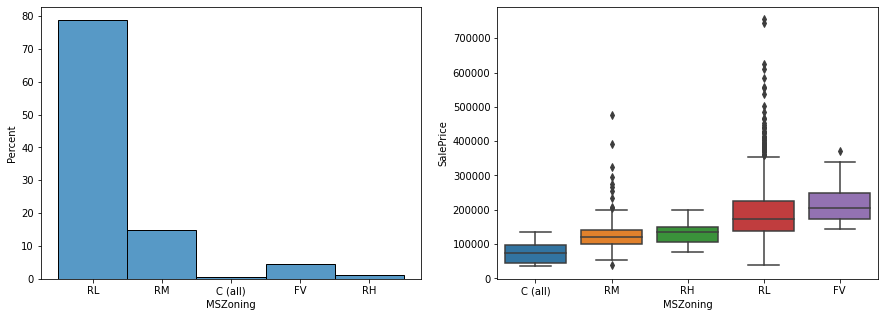

In [472]:
def plot(feature):
    subset = train[[feature, 'SalePrice']]
    s = subset.groupby([feature]).median().sort_values(by='SalePrice')
    
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(x = feature, data=train, stat='percent')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=feature, y='SalePrice', data=train, order=s.index)

plot(cat_features[0])

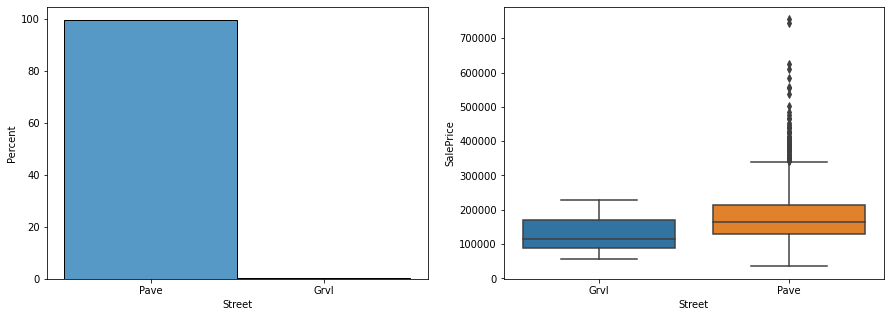

In [473]:
plot(cat_features[1])

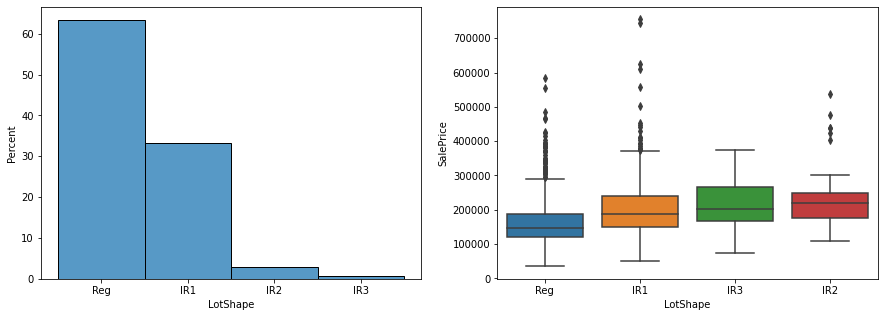

In [474]:
plot(cat_features[2])

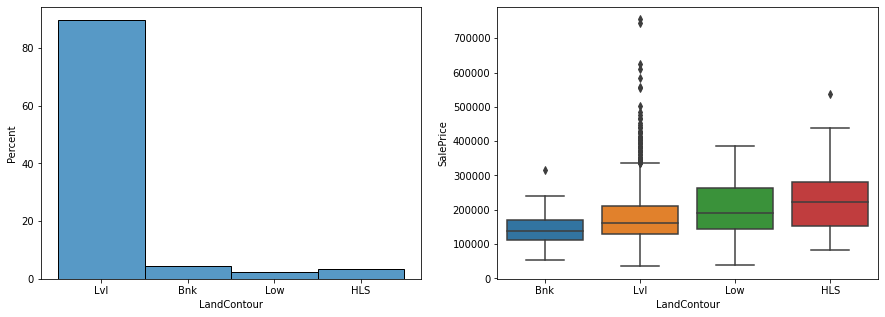

In [475]:
plot(cat_features[3])

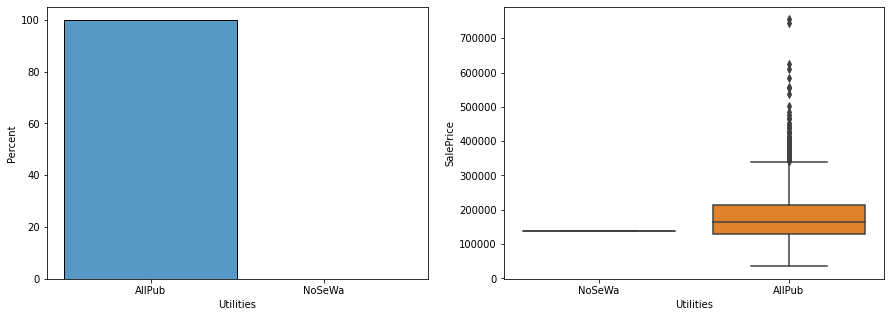

In [476]:
plot(cat_features[4])

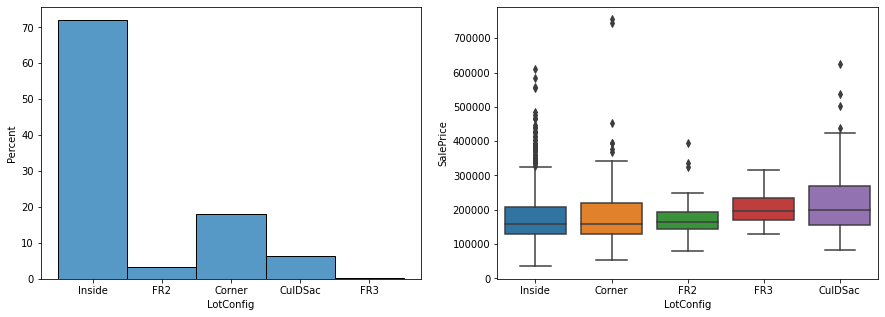

In [477]:
plot(cat_features[5])

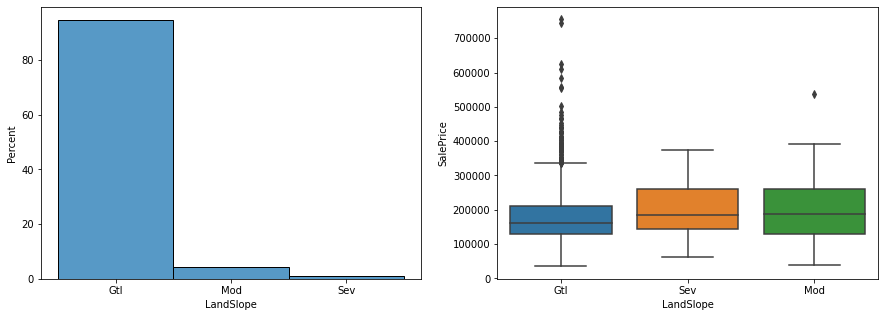

In [478]:
plot(cat_features[6])

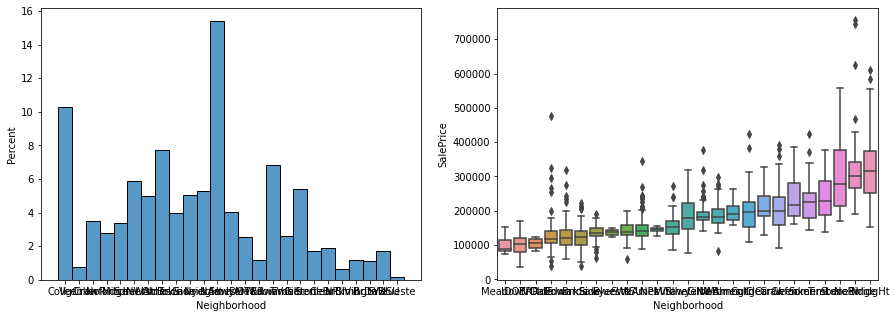

In [479]:
plot(cat_features[7])

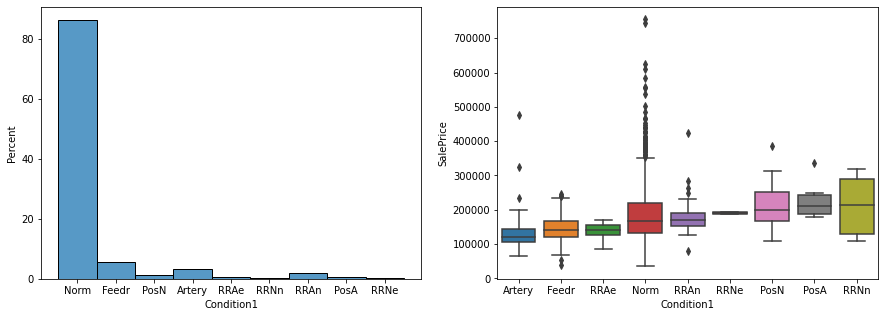

In [480]:
plot(cat_features[8])

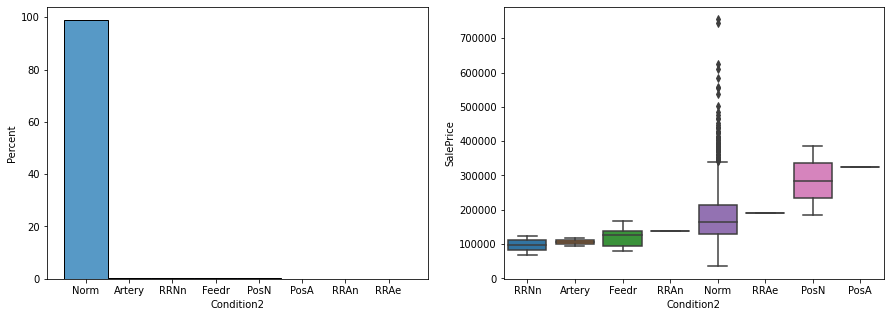

In [481]:
plot(cat_features[9])

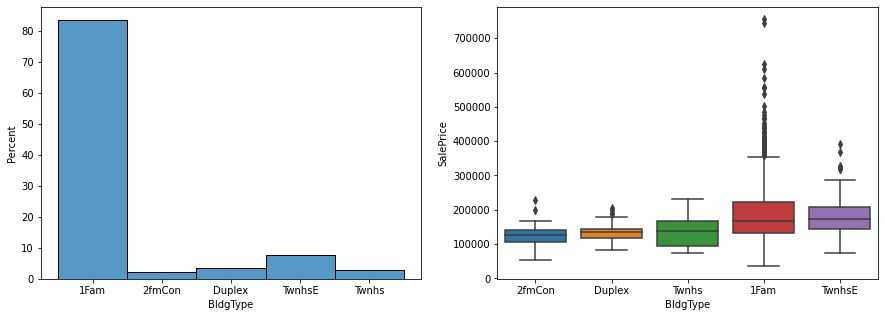

In [482]:
plot(cat_features[10])

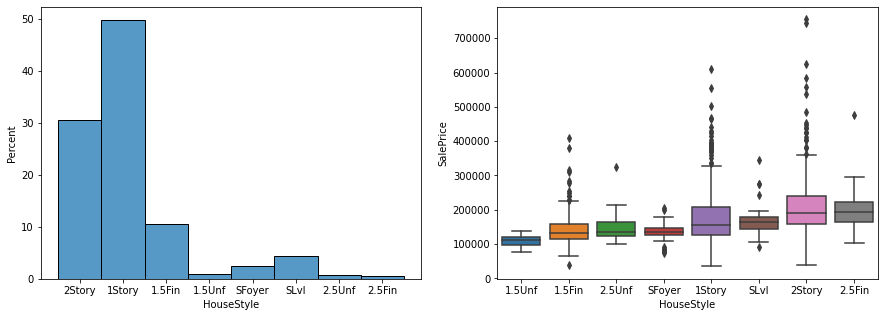

In [483]:
plot(cat_features[11])

- MSZoning
    - Order: I C FV A RH RM RL RP
- LotShape
    - R2 + R3 + R1 unite to 'irregular'
- Utilities
    - Remove column
- Street
    - Remove column
- LotConfig
    - Order: Inside FR2 Coner CullDSac FR3
    - Remove FR3
- LandSlope
    - Mod & Sev -> unite
    - Order: Gtl -> Other
- Condition2
    - Remove column
- BidgeType
    - Remove column


## **Encode categorical**

In [484]:
for f in cat_features:
    order = get_order(train, f)

    labels_dict = prepare_labels(order)
    labels_dict.update({'Missing': 0})

    CatEncoder.transform(train, f, labels_dict)
    CatEncoder.transform(test, f, labels_dict)

    train[f] = train[f].astype('int64')
    test[f] = test[f].astype('int64')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [485]:
train.dtypes

MSSubClass         int64
MSZoning           int64
LotFrontage      float64
LotArea            int64
Street             int64
                  ...   
MoSold             int64
YrSold             int64
SaleType           int64
SaleCondition      int64
SalePrice          int64
Length: 75, dtype: object

In [486]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,3,80.0,11622,2,1,2,2,1,1,10,2,5,4,5,5,6,1961,1961,2,3,12,14,2,0.0,2,5,4,3,4,2,4,468.0,4,144.0,270.0,882.0,6,3,2,6,896,0,0,896,0.0,0.0,1,0,2,1,2,5,7,0,6,1961.0,2,1.0,730.0,5,6,3,140,0,0,0,120,0,0,6,2010,6,5
1462,20,4,81.0,14267,2,2,2,2,2,1,10,4,5,4,5,6,6,1958,1958,4,3,6,3,3,108.0,2,5,4,3,4,2,5,923.0,5,0.0,406.0,1329.0,6,3,2,6,1329,0,0,1329,0.0,0.0,1,1,3,1,3,6,7,0,6,1958.0,2,1.0,312.0,5,6,3,393,36,0,0,0,0,12500,6,2010,6,5
1463,60,4,74.0,13830,2,2,2,2,1,1,14,4,5,4,7,5,5,1997,1998,2,3,12,14,2,0.0,2,5,6,4,4,2,7,791.0,5,0.0,137.0,928.0,6,4,2,6,928,701,0,1629,0.0,0.0,2,1,3,1,2,6,7,1,6,1997.0,4,2.0,482.0,5,6,3,212,34,0,0,0,0,0,3,2010,6,5
1464,60,4,78.0,9978,2,2,2,2,1,1,14,4,5,4,7,6,6,1998,1998,2,3,12,14,3,20.0,2,5,6,3,4,2,7,602.0,5,0.0,324.0,926.0,6,5,2,6,926,678,0,1604,0.0,0.0,2,1,3,1,3,7,7,1,6,1998.0,4,2.0,470.0,5,6,3,360,36,0,0,0,0,0,6,2010,6,5
1465,120,4,43.0,5005,2,2,4,2,1,1,23,4,5,5,5,8,5,1992,1992,2,3,9,9,2,0.0,3,5,6,4,4,2,5,263.0,5,0.0,1017.0,1280.0,6,5,2,6,1280,0,0,1280,0.0,0.0,2,0,2,1,3,5,7,0,6,1992.0,3,2.0,506.0,5,6,3,0,82,0,0,144,0,0,1,2010,6,5


In [487]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,3,80.0,11622,2,1,2,2,1,1,10,2,5,4,5,5,6,1961,1961,2,3,12,14,2,0.0,2,5,4,3,4,2,4,468.0,4,144.0,270.0,882.0,6,3,2,6,896,0,0,896,0.0,0.0,1,0,2,1,2,5,7,0,6,1961.0,2,1.0,730.0,5,6,3,140,0,0,0,120,0,0,6,2010,6,5
1462,20,4,81.0,14267,2,2,2,2,2,1,10,4,5,4,5,6,6,1958,1958,4,3,6,3,3,108.0,2,5,4,3,4,2,5,923.0,5,0.0,406.0,1329.0,6,3,2,6,1329,0,0,1329,0.0,0.0,1,1,3,1,3,6,7,0,6,1958.0,2,1.0,312.0,5,6,3,393,36,0,0,0,0,12500,6,2010,6,5
1463,60,4,74.0,13830,2,2,2,2,1,1,14,4,5,4,7,5,5,1997,1998,2,3,12,14,2,0.0,2,5,6,4,4,2,7,791.0,5,0.0,137.0,928.0,6,4,2,6,928,701,0,1629,0.0,0.0,2,1,3,1,2,6,7,1,6,1997.0,4,2.0,482.0,5,6,3,212,34,0,0,0,0,0,3,2010,6,5
1464,60,4,78.0,9978,2,2,2,2,1,1,14,4,5,4,7,6,6,1998,1998,2,3,12,14,3,20.0,2,5,6,3,4,2,7,602.0,5,0.0,324.0,926.0,6,5,2,6,926,678,0,1604,0.0,0.0,2,1,3,1,3,7,7,1,6,1998.0,4,2.0,470.0,5,6,3,360,36,0,0,0,0,0,6,2010,6,5
1465,120,4,43.0,5005,2,2,4,2,1,1,23,4,5,5,5,8,5,1992,1992,2,3,9,9,2,0.0,3,5,6,4,4,2,5,263.0,5,0.0,1017.0,1280.0,6,5,2,6,1280,0,0,1280,0.0,0.0,2,0,2,1,3,5,7,0,6,1992.0,3,2.0,506.0,5,6,3,0,82,0,0,144,0,0,1,2010,6,5


In [488]:
test['MSZoning'].value_counts()

4    1114
2     242
5      74
1      15
3      10
0       4
Name: MSZoning, dtype: int64

In [489]:
train['MSZoning'].value_counts()

4    1151
2     218
5      65
3      16
1      10
Name: MSZoning, dtype: int64

## **Feature Engineering**

In [490]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,4,65.0,8450,2,1,2,2,1,1,17,4,5,4,7,7,5,2003,2003,2,3,12,14,3,196.0,3,5,6,4,4,2,7,706,5,0,150,856,6,5,2,6,856,854,0,1710,1,0,2,1,3,1,3,8,7,0,6,2003.0,3,2,548,5,6,3,0,61,0,0,0,0,0,2,2008,6,5,208500
2,20,4,80.0,9600,2,1,2,2,3,1,20,2,5,4,5,6,8,1976,1976,2,3,7,5,2,0.0,2,5,4,4,4,5,5,978,5,0,284,1262,6,5,2,6,1262,0,0,1262,0,1,2,0,3,1,2,6,7,1,6,1976.0,3,2,460,5,6,3,298,0,0,0,0,0,0,5,2007,6,5,181500
3,60,4,68.0,11250,2,2,2,2,1,1,17,4,5,4,7,7,5,2001,2002,2,3,12,14,3,162.0,3,5,6,4,4,3,7,486,5,0,434,920,6,5,2,6,920,866,0,1786,1,0,2,1,3,1,3,6,7,1,6,2001.0,3,2,608,5,6,3,0,42,0,0,0,0,0,9,2008,6,5,223500
4,70,4,60.0,9550,2,2,2,2,2,1,19,4,5,4,7,7,5,1915,1970,2,3,6,4,2,0.0,2,5,2,3,5,2,5,216,5,0,540,756,6,4,2,6,961,756,0,1717,1,0,1,0,3,1,3,7,7,1,3,1998.0,2,3,642,5,6,3,0,35,272,0,0,0,0,2,2006,6,2,140000
5,60,4,84.0,14260,2,2,2,2,3,1,24,4,5,4,7,8,5,2000,2000,2,3,12,14,3,350.0,3,5,6,4,4,4,7,655,5,0,490,1145,6,5,2,6,1145,1053,0,2198,1,0,2,1,4,1,3,9,7,1,6,2000.0,3,3,836,5,6,3,192,84,0,0,0,0,0,12,2008,6,5,250000


### **If has garage feature**

In [491]:
train['HasGarage'] = np.where(train['GarageArea'] != 0, 1, 0)
test['HasGarage'] = np.where(test['GarageArea'] != 0, 1, 0)

### **Has Mas Vnr**

In [492]:
train['HasMasVnr'] = np.where(train['MasVnrArea'] != 0, 1, 0)
test['HasMasVnr'] = np.where(test['MasVnrArea'] != 0, 1, 0)

## **Skewness check, log Transform**

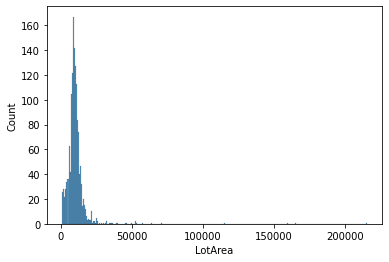

In [493]:
sns.histplot(train['LotArea'])

In [494]:
skewed_features = (train.skew().sort_values(ascending=False)).index
skewed_features

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'RoofMatl',
       'LowQualFinSF', 'KitchenAbvGr', 'BsmtFinSF2', 'LandSlope',
       'ScreenPorch', 'BsmtHalfBath', 'EnclosedPorch', 'MasVnrArea',
       'LandContour', 'LotConfig', 'LotFrontage', 'OpenPorchSF', 'SalePrice',
       'LotShape', 'BsmtFinSF1', 'WoodDeckSF', 'TotalBsmtSF', 'RoofStyle',
       'MasVnrType', 'MSSubClass', '1stFlrSF', 'GrLivArea', 'BsmtUnfSF',
       'ExterQual', '2ndFlrSF', 'BsmtExposure', 'OverallCond', 'TotRmsAbvGrd',
       'HalfBath', 'Fireplaces', 'BsmtFullBath', 'HasMasVnr', 'KitchenQual',
       'OverallQual', 'MoSold', 'BedroomAbvGr', 'GarageArea', 'Neighborhood',
       'Condition1', 'YrSold', 'FullBath', 'Exterior2nd', 'GarageCars',
       'Exterior1st', 'YearRemodAdd', 'HeatingQC', 'GarageFinish',
       'Foundation', 'YearBuilt', 'GarageYrBlt', 'HouseStyle', 'BsmtFinType1',
       'SaleType', 'GarageType', 'BsmtQual', 'MSZoning', 'SaleCondition',
       'BldgType', 'ExterCond', 'BsmtFinType2',

In [495]:
LogTransformer.transform(train, skewed_features, offset=0.001)
LogTransformer.transform(test, skewed_features.drop('SalePrice'), offset=0.001)

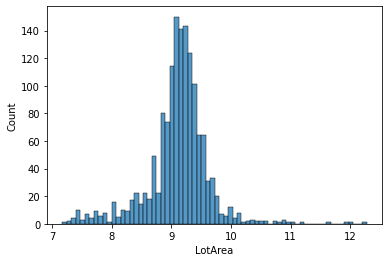

In [496]:
sns.histplot(train['LotArea'])

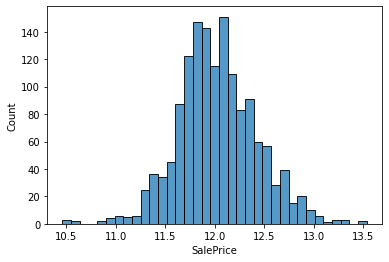

In [497]:
sns.histplot(train['SalePrice'])

In [498]:
train.skew().sort_values(ascending=True)

Utilities      -38.209946
Electrical     -22.903089
KitchenAbvGr   -16.601568
Street         -15.518770
Condition2     -14.886998
                  ...    
MiscVal          5.052355
RoofMatl         6.862016
LowQualFinSF     7.334348
3SsnPorch        7.638788
PoolArea        14.355068
Length: 77, dtype: float64

## **IQR Filter**

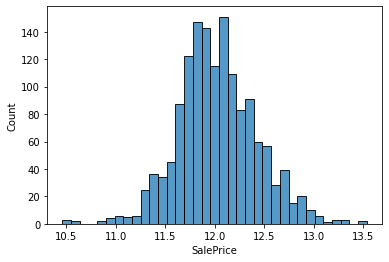

In [499]:
sns.histplot(train['SalePrice'])

In [500]:
#IQRRemover.transform(train, ['SalePrice'])
print(f'Size before: {train.shape}')
train = QuantileRemover.transform(train, ['SalePrice'], 0.02, 0.98)
print(f'Size after: {train.shape}')

Size before: (1460, 77)
Size after: (1401, 77)


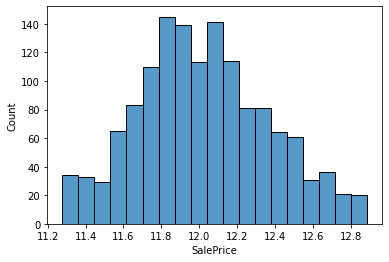

In [501]:
sns.histplot(train['SalePrice'])

In [502]:
nan_statistics(train), nan_statistics(test)

Col -- Nan percentage
Col -- Nan percentage


({}, {})

## **Select K best features**

In [503]:
# Choose numeric types and try SelectKBest features
target = train['SalePrice']
train.drop(columns=['SalePrice'], inplace=True)

In [504]:
features_selector = SelectKBest(score_func=f_classif, k=select_k_numerics)
fit = features_selector.fit(train, target)

In [505]:
feature_scores = pd.DataFrame({
    'Scores': pd.Series(fit.scores_),
    'Colnames': pd.Series(train.columns)
})
feature_scores = feature_scores.nlargest(select_k_numerics, 'Scores')

In [506]:
k_best_features = feature_scores['Colnames'].values

In [507]:
k_best_features

array(['MasVnrType', 'OverallQual', 'ExterQual', 'Neighborhood',
       'GrLivArea', 'KitchenQual', 'YearBuilt', 'BsmtQual', 'TotalBsmtSF',
       '1stFlrSF', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Foundation', 'FullBath', 'GarageYrBlt',
       'YearRemodAdd', 'Fireplaces', 'OpenPorchSF', 'TotRmsAbvGrd',
       'Exterior1st', 'Street', 'Heating', 'HalfBath', 'LotShape',
       'Exterior2nd', 'LotArea', 'MasVnrArea', 'WoodDeckSF'], dtype=object)

## **Heatmap for numerics**

In [508]:
train['SalePrice'] = target

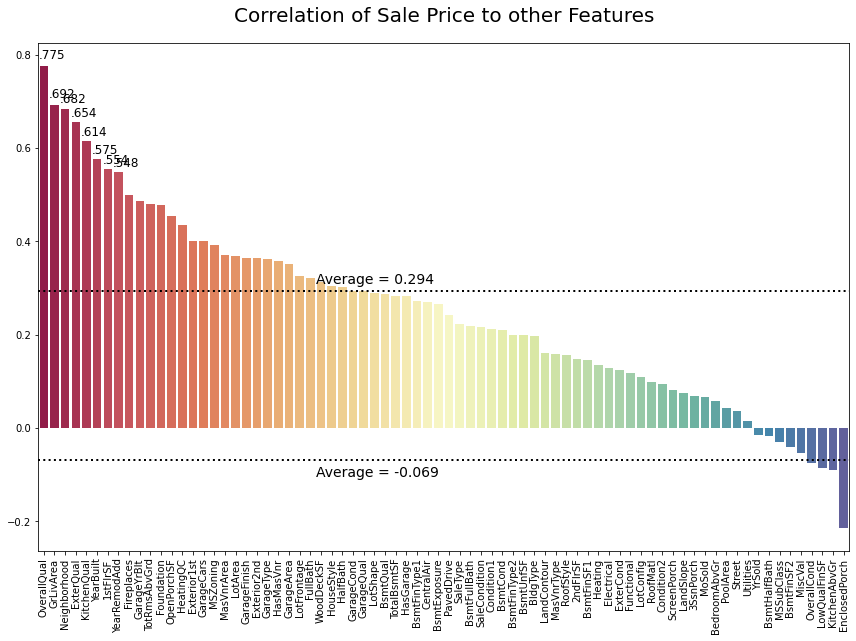

In [509]:
corrs = train.drop('SalePrice',axis=1).corrwith(train['SalePrice']).sort_values(ascending=False)

fig,axes=plt.subplots(1,1,figsize=(12,9))
axes.axhline(corrs[corrs>0].mean(), ls=':',color='black',linewidth=2)
axes.text(25.5,corrs[corrs>0].mean()+.015, "Average = {:.3f}".format(corrs[corrs>0].mean()),color='black',size=14)
axes.axhline(corrs[corrs<0].mean(), ls=':',color='black',linewidth=2)
axes.text(25.5,corrs[corrs<0].mean()-.035, "Average = {:.3f}".format(corrs[corrs<0].mean()),color='black',size=14)
sns.barplot(y=corrs,x=corrs.index,palette='Spectral')
plt.title('Correlation of Sale Price to other Features',size=20,color='black',y=1.03)
plt.xticks(rotation=90)
for p in axes.patches:
            value = p.get_height()
            if value <=.5:
                continue
            x = p.get_x() + p.get_width()-.9
            y = p.get_y() + p.get_height()+(.02*value)
            axes.text(x, y, str(value)[1:5], ha="left",fontsize=12,color='#000000')
plt.tight_layout()

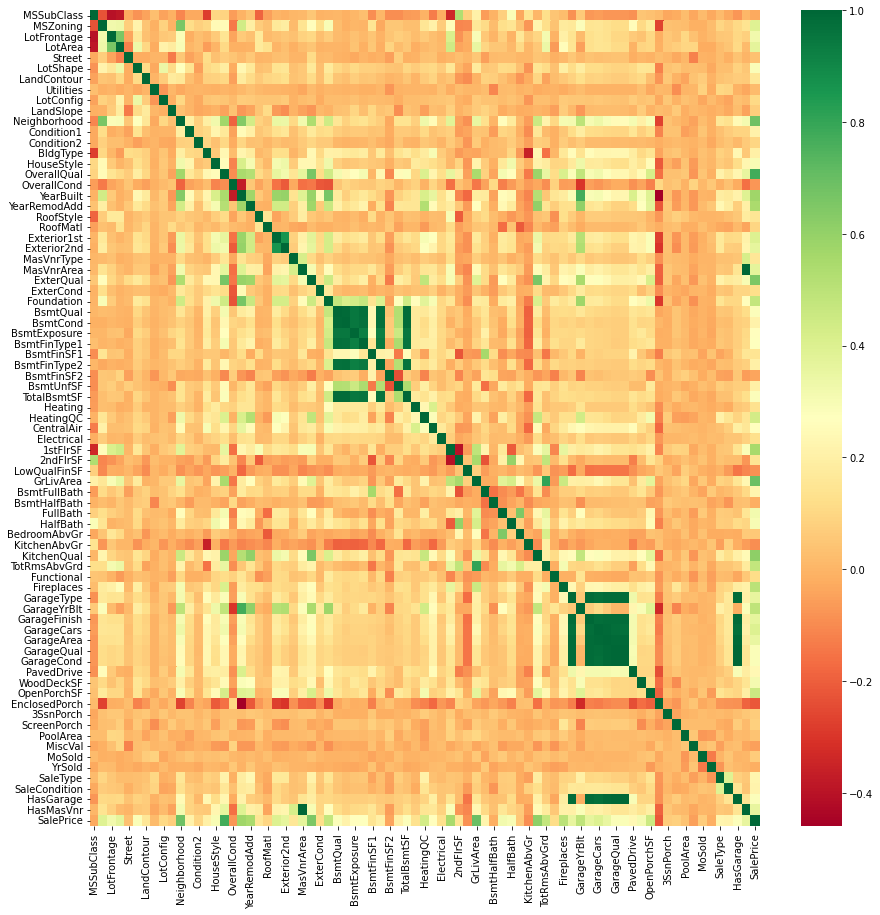

In [510]:
corr_matrix = train.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="RdYlGn")

**Insight. There are ~14 numeric features, highly correlated with the target**

In [511]:
corr_res = corr_filter(
    corr_matrix,
    target_feature='SalePrice',
    abs_thresh=0.4)
del corr_res['SalePrice']

In [512]:
best_fatures_corr = corr_res.keys()
set_k_best = set(k_best_features)
set_corr = set(best_fatures_corr)

## **Keep only relevant features**

In [513]:
features_to_keep = list(set_k_best.union(set_corr))
print(features_to_keep)
print(len(features_to_keep), 'SalePrice' in features_to_keep)

['WoodDeckSF', 'FullBath', 'YearBuilt', 'Fireplaces', 'Street', 'BsmtFinType2', 'TotRmsAbvGrd', 'BsmtCond', 'Exterior2nd', 'GrLivArea', 'KitchenQual', 'TotalBsmtSF', 'HeatingQC', 'Neighborhood', 'BsmtFinType1', 'YearRemodAdd', 'Exterior1st', 'Heating', 'MasVnrArea', 'BsmtQual', 'OpenPorchSF', 'ExterQual', 'GarageCars', 'Foundation', 'OverallQual', 'GarageYrBlt', '1stFlrSF', 'BsmtExposure', 'HalfBath', 'MasVnrType', 'LotArea', 'LotShape']
32 False


In [514]:
ColumnKeeper.transform(train, features_to_keep + ['SalePrice'])
ColumnKeeper.transform(test, features_to_keep)

In [515]:
train.shape, test.shape

((1401, 33), (1459, 32))

In [516]:
train.head()

,LotArea,Street,LotShape,Neighborhood,OverallQual,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,1stFlrSF,GrLivArea,FullBath,HalfBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9.041922,0.693147,0.000000,2.833213,1.945910,7.602401,7.602401,2.484907,2.639057,1.098612,5.278115,1.098612,1.791759,1.386294,1.386294,0.693147,1.945910,1.609438,6.752270,1.791759,1.609438,6.752270,7.444249,0.693147,0.000000,1.098612,2.079442,-6.907755,7.602401,0.693147,-6.907755,4.110874,12.247694
2,9.169518,0.693147,0.000000,2.995732,1.791759,7.588830,7.588830,1.945910,1.609438,0.693147,-6.907755,0.693147,1.386294,1.386294,1.386294,1.609438,1.609438,1.609438,7.140453,1.791759,1.609438,7.140453,7.140453,0.693147,-6.907755,0.693147,1.791759,0.000000,7.588830,0.693147,5.697093,-6.907755,12.109011
3,9.328123,0.693147,0.693147,2.833213,1.945910,7.601402,7.601902,2.484907,2.639057,1.098612,5.087596,1.098612,1.791759,1.386294,1.386294,1.098612,1.945910,1.609438,6.824374,1.791759,1.609438,6.824374,7.487734,0.693147,0.000000,1.098612,1.791759,0.000000,7.601402,0.693147,-6.907755,3.737670,12.317167
4,9.164296,0.693147,0.693147,2.944439,1.945910,7.557473,7.585789,1.791759,1.386294,0.693147,-6.907755,0.693147,0.693147,1.098612,1.609438,0.693147,1.609438,1.609438,6.628041,1.791759,1.386294,6.867974,7.448334,0.000000,-6.907755,1.098612,1.945910,0.000000,7.599902,1.098612,-6.907755,3.555348,11.849398
5,9.565214,0.693147,0.693147,3.178054,2.079442,7.600902,7.600902,2.484907,2.639057,1.098612,5.857933,1.098612,1.791759,1.386294,1.386294,1.386294,1.945910,1.609438,7.043160,1.791759,1.609438,7.043160,7.695303,0.693147,0.000000,1.098612,2.197225,0.000000,7.600902,1.098612,5.257495,4.430817,12.429216


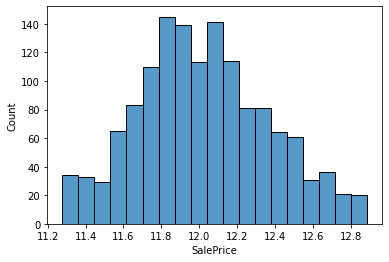

In [517]:
sns.histplot(train['SalePrice'])

## **Train Validation split (& Log transform of target)**

In [518]:
y = train['SalePrice']
train.drop(columns=['SalePrice'], inplace=True)

In [519]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    train, 
    y,
    train_size=train_proportion,
    random_state=rand_state
)

In [520]:
X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape

((1260, 32), (141, 32), (1260,), (141,))

## **Pipeline for features scaling + Transformers**

In [521]:
num_features = list(train.select_dtypes(include=['int64', 'float64']).columns)
cat_features = list(train.select_dtypes(include=['O']).columns)

print(cat_features)
print(num_features)

[]
['LotArea', 'Street', 'LotShape', 'Neighborhood', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'TotalBsmtSF', 'Heating', 'HeatingQC', '1stFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF']


In [522]:
num_pipeline = Pipeline(
    steps = [
             ('imputer', SimpleImputer()),
             ('scaler', RobustScaler())
    ]
)
num_transformer = FeaturesTransformers(num_features, num_pipeline)

## **Approximate tune, try models**

In [ ]:
models = [
          #('Regression', LinearRegression()),
          #('RF', RandomForestRegressor()),
          ('CatBoost', CatBoostRegressor(verbose=0)),
          ('XGB', XGBRegressor()),
          ('Elastic', ElasticNet()),
          #('SVR', SVR()),
          ('GradientBoost', GradientBoostingRegressor()),
          ('LGBM', LGBMRegressor())
          #('SGD', SGDRegressor())
]

res_dict = first_tune(
    models,
    scoring='neg_mean_squared_error',
    X_train=X_train_val,
    Y_train=y_train_val,
    transformers = dict(
        num=num_transformer
    )
)
d_sorted = {k:v.mean() for k, v in sorted(res_dict.items(), key = lambda item: item[1].mean())}
d_sorted

[11:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'CatBoost': -0.016894650297906242,
 'Elastic': -0.1549471147999328,
 'GradientBoost': -0.019028994037649904,
 'LGBM': -0.019914242875806974,
 'XGB': -0.018925463490975382}

**Cat Boost Regression shows best metrics**

## **Model fine tune**

In [523]:
catboost_models = [(
    'CatBoost',
    CatBoostRegressor(verbose=0),{
        'model__depth': [4, 6],
        'model__learning_rate': [0.03, 0.1],
        'model__iterations': [100, 150, 200],
        'model__l2_leaf_reg': [0.3, 0.5, 1]
    }
)]

catboost_res = fine_tune(
    catboost_models,
    X_train_val,
    y_train_val,
    strategy='GridSearchCV',
    search_params = dict(
        verbose=3,
        return_train_score=True,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error',
        cv=6
    ),
    transformers = dict(
        numeric = num_transformer
    )
)

{'verbose': 3, 'return_train_score': True, 'n_jobs': -1, 'scoring': 'neg_root_mean_squared_error', 'cv': 6}
Fitting 6 folds for each of 36 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.5min finished


## **Best Model Selection**

In [524]:
best_model_score = catboost_res['CatBoost'].best_score_
best_estimator = catboost_res['CatBoost'].best_estimator_
print(best_model_score)

-0.1134287579334796


In [531]:
best_estimator.fit(X_train_val, y_train_val)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                          

In [527]:
predicted = best_estimator.predict(X_test)
print(mean_squared_error(predicted, y_test))

0.011496532037648874


# **Submission**

In [528]:
best_estimator.fit(train, y)
final_predictions = np.exp(best_estimator.predict(test))

In [529]:
final_predictions

array([119948.76859817, 155719.34370961, 183760.05033173, ...,
       157638.57533892, 121589.18416492, 203658.78857734])

In [530]:
sample_submission = pd.read_csv(sample_submission_path, index_col='Id')
submission = pd.DataFrame({
    'Id': sample_submission.index,
    'SalePrice': final_predictions
})
submission.to_csv(submission_path, index=False)